In [147]:
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import convex_hull_image, convex_hull_object
import skimage.filters as skf
import glob
import os
import numpy as np

import matplotlib as mpl
mpl.rc('image', cmap='gray')
mpl.rc('patch', ec='k', fc='k')
mpl.rc('lines', c='k')

In [2]:
image_path = "/pscratch/sd/a/ajtritt/SDBR/bisabolene_CN/S4"

In [3]:
images = list()
hts = list()
for subdir in glob.glob(f"{image_path}/*"):
    hts.append(os.path.basename(subdir))
    
    images.append(cv.cvtColor(cv.imread(glob.glob(os.path.join(subdir, f"*_10.tif"))[0]), cv.COLOR_BGR2GRAY))
images = np.array(images)

# Some functions for viewing images and the results of segmentations

In [169]:
import matplotlib.patches as patches
def calc_box(mask):
    mask = mask.astype(int)
    Y, X = np.where(mask == 1)
    Xx, Xn = X.max(), X.min()
    Yx, Yn = Y.max(), Y.min()
    return patches.Rectangle((Xn, Yx), Xx-Xn, Yn-Yx, linewidth=1, edgecolor='r', facecolor='none')


def trim_box(mask, img):
    mask = mask.astype(int)
    Y, X = np.where(mask == 1)
    Xx, Xn = X.max(), X.min()
    Yx, Yn = Y.max(), Y.min()
    return img[Yn: Yx, Xn: Xx]

    
def plot_images(func=lambda x: x, draw_box=False, draw_mask=True):
    fig, axes = plt.subplots(3, 4, figsize=(8, 6))
    for img, ax, ht in zip(images, axes.ravel(), hts):
        ax.tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
        tmp_img = func(img)
        if draw_mask:
            ax.imshow(tmp_img, cmap='gray')
        else:
            ax.imshow(img, cmap='gray')
        ax.set_xlabel(f"{ht} - {img.mean():.1f}")
        if draw_box:
            patch = calc_box(tmp_img)
            ax.add_patch(patch)
            

## View some images

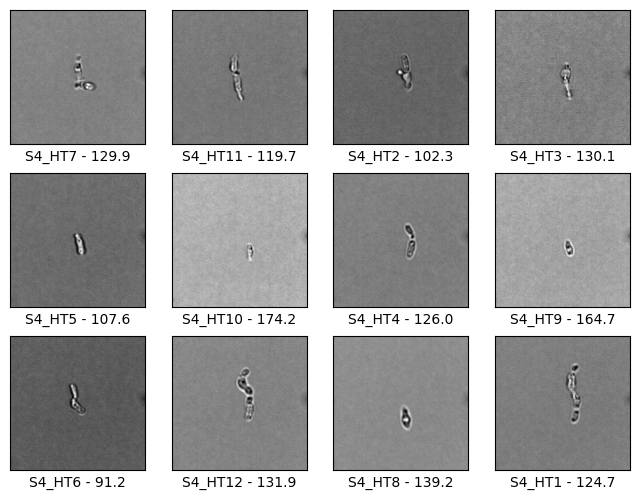

In [115]:
plot_images()
plt.savefig('samples.png')

## Standard Otsu thresholding

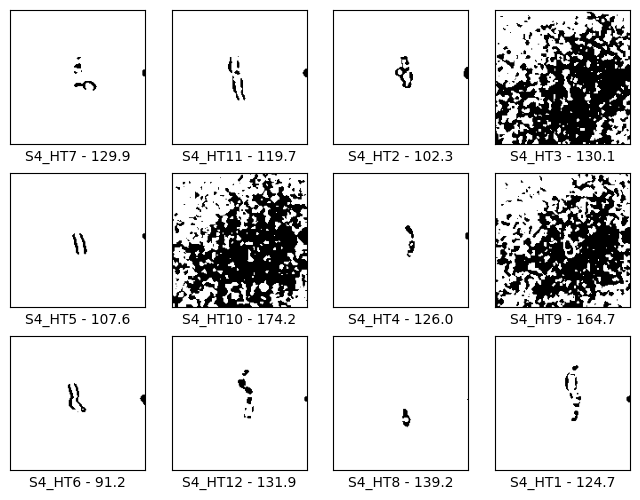

In [103]:
def threshold(img):
    blur = cv.GaussianBlur(img, (5, 5),0)   
    _thresh = blur[:5, :5].mean()
    return cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)[1]
plot_images(threshold)

### A closer look
Lets zoom in and look closer at a single cell.

Here, we can see that the cell is composed of pixels above and below the average pixel value

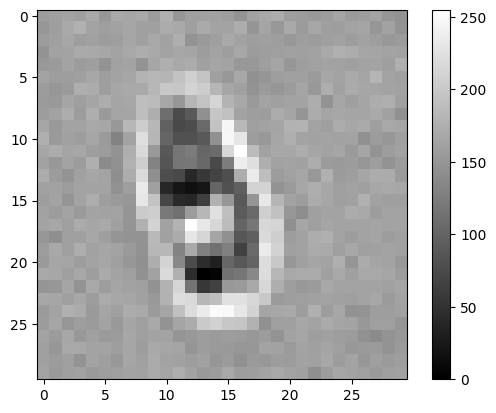

In [118]:
plt.imshow(images[7][70:100][:, 70:100])
plt.colorbar()

### Histogram of the pixels

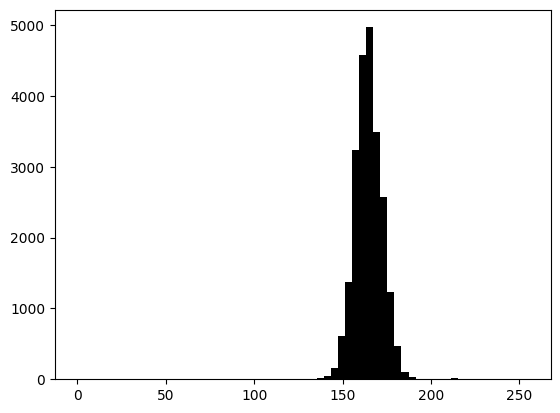

In [149]:
plt.hist(images[7].ravel(), bins=64, color='k');

### Ignore the tails
Let's see what $1 \sigma$ looks like

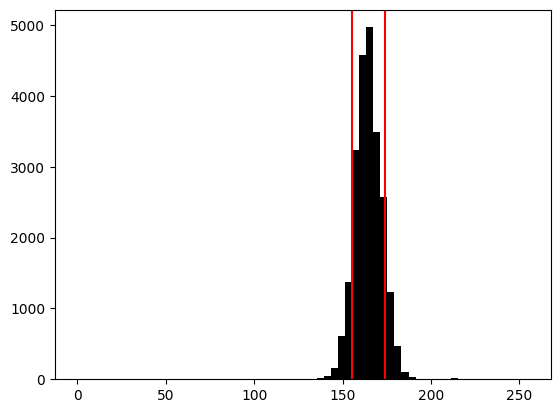

In [150]:
img = images[7]
plt.hist(img.ravel(), bins=64, color='k');
mean = img.ravel().mean()
std = img.ravel().std()
nsig = 1
plt.axvline(mean - nsig*std, color='r')
plt.axvline(mean + nsig*std, color='r')

## Outlier thresholding
Make mask based on values that are $N \sigma$ from the mean.


First, lets ignore data at the borders (it appears there are some imaging artefacts). Then threshold above and below $N \sigma$ away from the mean. By default, $N = 1$. Finally, apply successive median filters to get rid of any extra noise.

In [154]:
def outlier_threshold_tol(img, tol=0.001, max_med=10, ntrim=15, nsig=1):
    """
    Args:
        tol (float)      : the tolerance for applying successive median filters. If the change is less than this, stop applying filters
        max_med (int)    : the maximum number of median filters to apply
        ntrim (int)      : the size of the border to ignore
        nsig (int)       : the number of standard deviations above/below which to keep set the threshold
    """
    mean = img.ravel().mean()
    std = img.ravel().std()
    mask = np.logical_or(img < mean - nsig*std, img > mean + nsig*std).astype(int)
    mask[:ntrim] = 0
    mask[-ntrim:] = 0
    mask[:, :ntrim] = 0
    mask[:, -ntrim:] = 0
    
    for i in range(max_med):
        tmp = skf.median(mask.astype(int))
        diff = (mask != tmp).mean()
        if diff < tol:
            break
        mask = tmp

    return mask
outlier_threshold_tol(images[5], max_med=8);

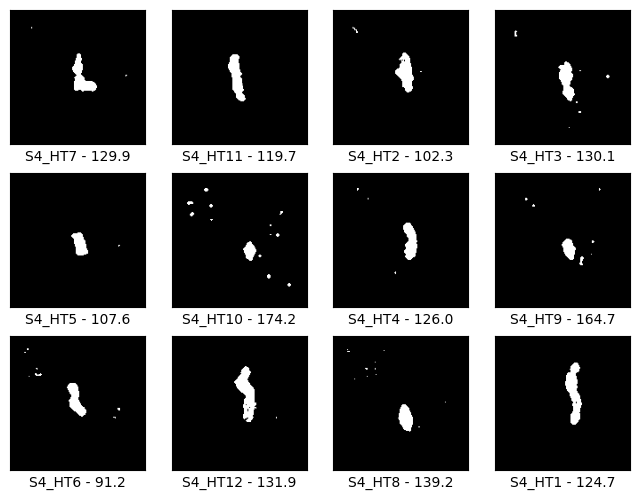

In [156]:
plot_images(outlier_threshold_tol)

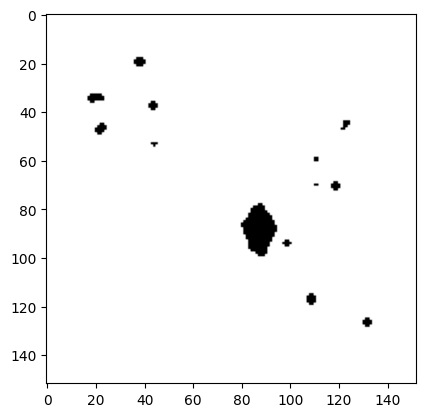

In [158]:
plt.imshow(outlier_threshold_tol(images[5]), cmap='Greys')

## Filter any remaining noise.

As we can see in some of the thresholded figures above, we still get some noise. Lets get rid of that by clustering the remaining pixels, and keeping the largest cluster we find. To do this, we will use DBSCAN, and set $\epsilon = \sqrt{2}$ i.e. points are only considered neighbors if they are within one pixel to each other. Then, lets keep only the cluster that has more than half of the clustered pixels. If we cannot find one of these, we will raise an error to make sure this doesn't cascade downstream.

It's worth noting here that HDBSCAN was tested here, but it did not work as well as DBSCAN. The $\epsilon$ parameter, as much of a nuisance as it usually is, is a strength of the original DBSCAN algorithm in this context. This parameter allows us to require pixels to be exactly adjacent when clustering

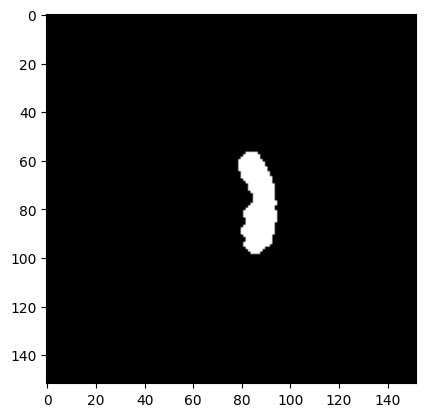

In [167]:
from sklearn.cluster import DBSCAN

def outlier_cluster(img):
    thresh = outlier_threshold_tol(img)
    dbscan = DBSCAN(eps=1.4142135623730951)
    dat = np.array(np.where(thresh)).T
    labels = dbscan.fit_predict(dat)
    counts = np.bincount(labels[labels >= 0])
    cell_cluster_id = np.where((counts / counts.sum()) > 0.5)[0]
    if len(cell_cluster_id) == 0:
        raise ValueError("Unable to find one majority cluster")

    cell_cluster_id = cell_cluster_id[0]
    X, Y = dat[labels == cell_cluster_id].T
    mask = np.zeros_like(thresh)
    mask[X, Y] = 1
    return mask
plt.imshow(outlier_cluster(images[6]), cmap='gray')

### Test out this segmentation on other images

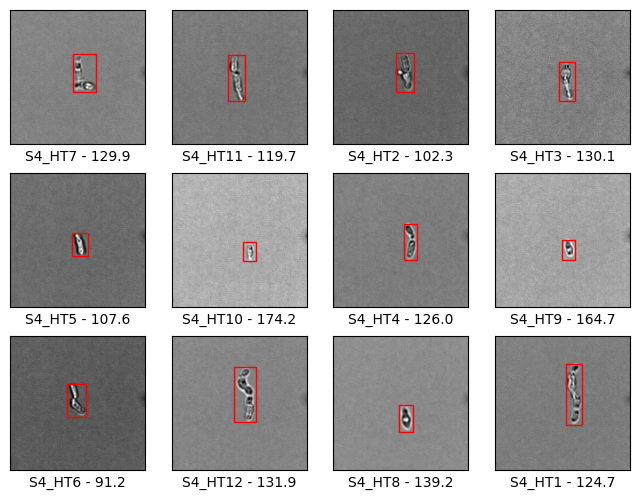

In [164]:
plot_images(outlier_cluster, draw_box=True, draw_mask=False)

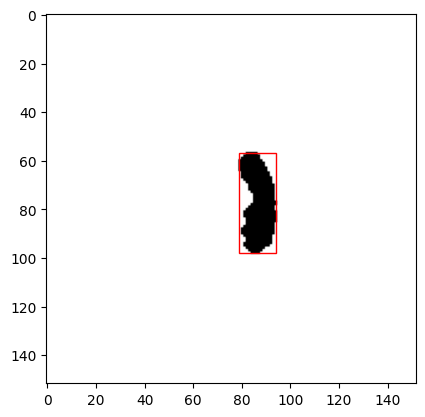

In [99]:
mask = outlier_cluster(images[6])
plt.imshow(mask, cmap='Greys')
plt.gca().add_patch(calc_box(mask))

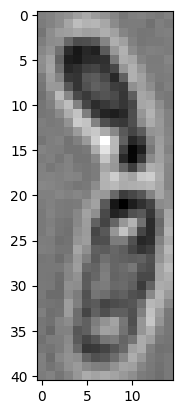

In [170]:
mask = outlier_cluster(images[6])
new_img = trim_box(mask, images[6])
plt.imshow(new_img, cmap='gray')